<h1><center>Machine Learning for Finance Project</center></h1>

Course of ML for Finance - 
Jean-David Fermanian & Huyên PHAM $-$ ENSAE 3rd year  
$\texttt{ryan.boustany@ensae.fr}$ ⎜ $\texttt{nathan.boyer@ensae.fr}$ ⎜ $\texttt{paul.couairon@ensae.fr}$

## Table of Contents
1. [Introduction](#Introduction)
2. [Data exploration](#Dataexploration)
3. [Preprocessing](#Preprocessing)
4. [Neural network topologies](#Neural)
5. [Generative adversarial networks](#GAN)
6. [The Model](#model)
    

<h1><center>Abstract</center></h1>

In this Notebook we propose a detailed study and an implementation of the article of Magnus Wiese, Robert Knobloch, Ralf Korn and Peter Kretschmer : *Quant GANs:
Deep Generation of Financial Time Series*. The idea is to propose a new algorithm to model financial time series with Quant GANs. That consists of a generator and discriminator function which utilize temporal convolutional networks (TCNs) and thereby achieve to capture long-range dependencies such as the presence of volatility clusters.

## Introduction 

### Preamble

In this article, the authors consider the problem of approximating a realistic asset price simulator by using neural networks (NNs) and adversarial training techniques. Such a path simulator is useful as it can be used to extend and enrich limited real-world datasets, which in turn can be used either to fine-tune or robustify financial trading strategies.


To approximate a data-driven path simulator the authors propose Quant GANs. Quant GANs are based on the application of generative adversarial networks (GANs) (Goodfellow et al., 2014) and are located between pure data-based approaches such as historical simulation and model-driven methods such as Monte Carlo simulation assuming an underlying stock price model like the Black Scholes model (Black and Scholes, 1973), the Heston stochastic volatility model (Heston, 1993) or Lévy process based modeling (Tankov, 2003).

Using two different NNs as opponents is the fundamental principle of GANs. While one NN (the generator), is responsible for the generation of stock price paths, the second one (the discriminator) has to judge whether the generated paths are synthetic or from the same underlying distribution as the data (i.e. the past prices).

Various pitfalls exist when training **GANs** ranging from limited convergence when optimizing both networks simultaneously (cf. Arjovsky and Bottou (2017); Mescheder et al. (2018)) to extrapolation problems when using recurrent generation schemes. To address the latter issue the authors propose the use of **temporal convolutional networks (TCNs)**, also known as WaveNets (van den Oord et al., 2016), as the generator architecture. 

A **TCN** generator comes with multiple benefits: it is particularly suited for modeling long-range dependencies, allows for parallization and guarantees stationarity. This TCN architecture is a key point in the Quant GANs method.  

### Main thread

On the article, the authors present lots of Deep Learning notion. In fact, after introducing NNs (and in particular TCNs) in Section 3 and GANs in Section 4, they define the proposed generator architecture of Quant GANs, namely Stochastic Volatility Neural Networks (SVNNs) in Section 5. In spirit of stochastic volatility models, the SVNN architecture consists of a volatility and drift TCN and an innovation NN. SVNNs are constructed such that the generated paths can be evaluated under their risk-neutral distribution and, as a special case, constrained to exhibit conditionally normal log returns.

For SVNNs, the authors prove theoretical claims, which demonstrate that all moments of the process exist. 
Indeed, they show that the $Lambert \; W$ transformation plays an essential role for generating heavy-tailed stock price returns by using methods for normalized Gaussian data.
In Section 7 of the article, they present a numerical study applying Quant GANs to the S&P 500 index from May 2009 - December 2018 (see figure below). Our goal is to reproduce their results to  demonstrate that SVNNs and TCNs outperform a typical GARCH-model with respect to distributional and dependence properties.

## Data exploration

During this project, we will present a numerical study applying Quant GANs to the S&P 500 index from May 2009 - December 2018. According to the authors, the results demonstrate that GANs can outperform a typical GARCH-model with respect to distributional and dependence properties.

In [ ]:
! wget https://raw.githubusercontent.com/ryanboustany/ml-finance/main/data/sp500.csv
! wget https://raw.githubusercontent.com/ryanboustany/ml-finance/main/utils/gaussianize.py

--2021-04-25 14:49:11--  https://raw.githubusercontent.com/ryanboustany/ml-finance/main/data/sp500.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170976 (167K) [text/plain]
Saving to: ‘sp500.csv’

sp500.csv           100%[===================>] 166.97K  --.-KB/s    in 0.005s  

2021-04-25 14:49:11 (33.1 MB/s) - ‘sp500.csv’ saved [170976/170976]

--2021-04-25 14:49:11--  https://raw.githubusercontent.com/ryanboustany/ml-finance/main/utils/gaussianize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12550 (12K) [text/plain]
Sa

In [ ]:
## a few imports

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from scipy.special import lambertw
import scipy.stats as stats
import tensorflow as tf
import gaussianize as g

sns.set()

In [ ]:
! nvidia-smi

Sun Apr 25 14:49:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data = pd.read_csv('sp500.csv')

In [ ]:
data['Dernier'] = data['Dernier'].apply(lambda x: x.replace('.', '').replace(',', '.'))
data['Ouv.'] = data['Ouv.'].apply(lambda x: x.replace('.', '').replace(',', '.'))
data['Plus Haut'] = data['Plus Haut'].apply(lambda x: x.replace('.', '').replace(',', '.'))
data['Plus Bas'] = data['Plus Bas'].apply(lambda x: x.replace('.', '').replace(',', '.'))

data['Dernier'] = data['Dernier'].astype(float)
data['Ouv.'] = data['Ouv.'].astype(float)
data['Plus Haut'] = data['Plus Haut'].astype(float)
data['Plus Bas'] = data['Plus Bas'].astype(float)

data = data.iloc[::-1] # increasing date

In [ ]:
data.head()

,Date,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %
2433,01/05/2009,877.52,872.74,880.48,866.10,-,"0,54%"
2432,04/05/2009,907.24,879.21,907.85,879.21,-,"3,39%"
2431,05/05/2009,903.80,906.10,907.70,897.34,-,"-0,38%"
2430,06/05/2009,919.53,903.95,920.28,903.95,-,"1,74%"
2429,07/05/2009,907.39,919.58,929.58,901.36,-,"-1,32%"


## Preprocessing

In this section, we briefly collect some facts and modeling issues of financial time series, which motivate the choice of NN types. 

First, we note that the performance of a stock over a certain period (as e.g. a day, a month or a year) is given by its relative return, either $R_{t}=\left(S_{t}-S_{t-1}\right) / S_{t-1}$ or its log return $R_{t}=\log \left(S_{t}\right)-\log \left(S_{t-1}\right)$. Therefore, the generation of asset returns is the main objective of this paper. 

The characteristic properties of asset returns are well-studied and commonly known as stylized facts. A list of the most important stylized facts includes (see e.g. Chakraborti et al. (2011); Cont (2001)):
- asset returns admit heavier tails than the normal distribution
- the distribution of asset returns seems to be more peaked than the normal one,
- asset returns admit phases of high activity and low activity in terms of price changes, an effect which is called volatility clustering
- the volatility of asset returns is negatively correlated with the return process, an effect named leverage effect - empirical asset returns are considered to be uncorrelated but not independent.

According to the article, prior to passing a realization of a financial time series $s_{0: T} \in \mathbb{R}^{N_{X} \times(T+1)}$ to the discriminator, the time series has to be preprocessed. The applied pipeline is displayed below.

We will briefly explain each of the steps taken. 

Also, observe that the pipeline includes the inverse $Lambert \; W$ transformation and the authors explain why it's important.

<center><img src="https://github.com/ryanboustany/ml-finance/blob/main/image/Preprocessing.png?raw=true" width=500px></center>

**Step 1:** Log returns $r_{1: T}$
Calculate the log return series
$$
r_{t}=\log \left(\frac{s_{t}}{s_{t-1}}\right) \quad \text { for all } t \in\{1, \ldots, T\}
$$

Text(0, 0.5, 'Log return')

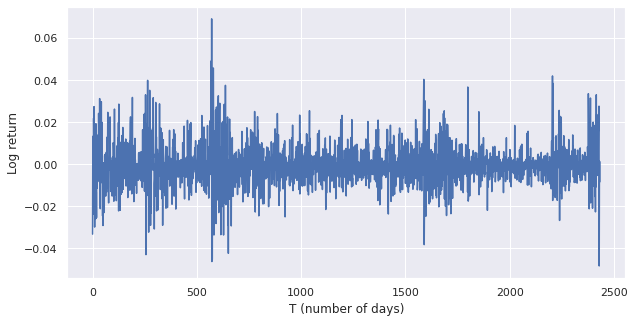

In [ ]:
log_return = np.log(np.array(data['Dernier'][:-1]) / np.array(data['Dernier'][1:]))
plt.figure(figsize=(10, 5))
x = np.arange(0, len(log_return))
plt.plot(x, log_return)
plt.xlabel('T (number of days)')
plt.ylabel('Log return')

For numerical reasons, we normalize the data in order to obtain a series with zero mean and unit variance, which is derived in LeCun et al. (1998).

Text(0, 0.5, 'Normalized log return')

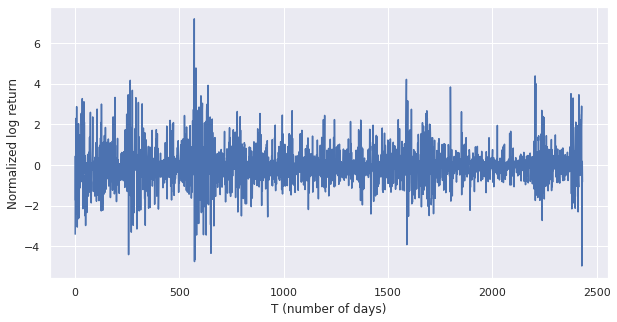

In [ ]:
mean, std = np.mean(log_return), np.std(log_return)
norm_log_return = (log_return - mean)/ std

data = data[:-1].reset_index()
data['norm_log_return'] = norm_log_return

plt.figure(figsize=(10, 5))
x = np.arange(0, len(norm_log_return))
plt.plot(x, norm_log_return)
plt.xlabel('T (number of days)')
plt.ylabel('Normalized log return')

**Step 3 & 4:** Location-scale Lambert and Normalize

The location-scale $Lambert \; W \times F_X$ transformed random variable $Y$ is defined by:

$$ Y = U \times exp\left(\frac{\delta}{2} U^2\right) \sigma + \mu $$

The suggested transformation applied to the log returns of the S&P 500 is displayed below. It shows the standardized original distribution of the S&P 500 log returns and the inverse $Lambert W$ transformed log return distribution. We observe that the transformed standardized log return distribution below approximately follows the standard normal distribution and thereby circumvents the issue of not being able to generate the heavy-tail of the original distribution.

In [ ]:
out = g.Gaussianize()
out.fit(data['norm_log_return'])  # Learn the parameters for the transformation
y = out.transform(data['norm_log_return'])  # Transform x to y, where y should be normal
mean_y, std_y = np.mean(y), np.std(y)

y = (y - mean_y) / std_y # Normalize

data['gaussian_returns'] = y

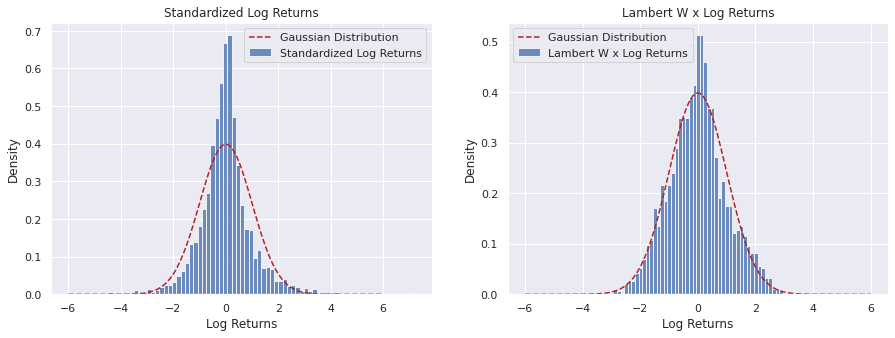

In [ ]:
x = np.linspace(-6, 6, 100)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(data['norm_log_return'], bins=75, density=True, label='Standardized Log Returns', alpha=0.8)
ax[0].plot(x, stats.norm.pdf(x) , '--', color='firebrick', label='Gaussian Distribution')
#ax[0].plot(x, stats.norm.pdf(x)*np.exp(10*stats.norm.pdf(x)**2/2)*0.5, '--', color='forestgreen', label='Gaussian Distribution')

ax[0].set_xlabel('Log Returns')
ax[0].set_ylabel('Density')
ax[0].set_title('Standardized Log Returns')
ax[0].legend()



ax[1].hist(y, bins=50, density=True, label='Lambert W x Log Returns', alpha=0.8)
ax[1].plot(x, stats.norm.pdf(x) , '--', color='firebrick', label='Gaussian Distribution')
ax[1].set_xlabel('Log Returns')
ax[1].set_ylabel('Density')
ax[1].set_title('Lambert W x Log Returns')
ax[1].legend()

plt.show()

We can also trace the log path : 

Text(0, 0.5, 'Log path')

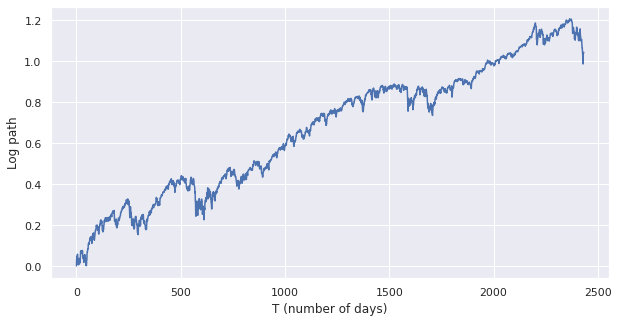

In [ ]:
log_path = np.log(data['Dernier']/data['Dernier'][0])
data['log_path'] = log_path
plt.figure(figsize=(10, 5))
x = np.arange(0, len(log_path))
plt.plot(x, np.log(data['Dernier']/data['Dernier'][0]))
plt.xlabel('T (number of days)')
plt.ylabel('Log path')

## Neural network topologies

In this section, we introduce the NN topologies that are essential to construct SVNNs. First, the multilayer perceptron (MLP) is defined. Afterward, we provide a formal definition of TCNs.

### Multilayer perceptrons

The MLP lies at the core of deep learning models. It is constructed by composing affine transfor- mations with so-called activation functions; non-linearities that are applied element-wise. Figure bewlow depicts the construction of an MLP with two hidden layers, where the input is three-dimensional and the output is one-dimensional. We begin with the activation function as the crucial ingredient and then define the MLP formally.

<center><img src="https://github.com/ryanboustany/ml-finance/blob/main/image/mlp.png?raw=true" width=400px></center>

**Definition 1 :** (Activation function). A function $\phi: \mathbb{R} \rightarrow \mathbb{R}$ that is Lipschitz continuous and monotonic is called activation function.


**Definition 2 :** (Multilayer perceptron). Let $L, N_{0}, \ldots, N_{L+1} \in \mathbb{N}, \phi$ an activation function, $\Theta$ an Euclidean vector space and for any $l \in\{1, \ldots, L+1\}$ let $a_{l}: \mathbb{R}^{N_{l-1}} \rightarrow \mathbb{R}^{N_{l}}$ be an affine mapping. A function $f: \mathbb{R}^{N_{0}} \times \Theta \rightarrow \mathbb{R}^{N_{L+1}}$, defined by


$$
f(x, \theta)=a_{L+1}^{\mathrm{I}} \circ f_{L} \circ \cdots \circ f_{1}(x)
$$
where $\circ$ denotes the composition operator,
$$
f_{l}=\phi \circ a_{l} \quad \text { for all } \quad l \in\{1, \ldots, L\}
$$
and $\phi$ being applied component-wise, is called a multilayer perceptron with $L$ hidden layers. In this setting $N_{0}$ represents the input dimension, $N_{L+1}$ the output dimension, $N_{1}, \ldots, N_{L}$ the hidden dimensions and $a_{L+1}$ the output layer. Furthermore, for any $l \in\{1, \ldots, L+1\}$ the function $a_{l}$ takes the form $a_{l}: x \mapsto W^{(l)} x+b^{(l)}$ for some weight matrix $W^{(l)} \in \mathbb{R}^{N_{l} \times N_{l-1}}$ and bias $b^{(l)} \in \mathbb{R}^{N_{i}}$. With this representation, the MLP's parameters are defined by
$$
\theta:=\left(W^{(1)}, \ldots, W^{(L+1)}, b^{(1)}, \ldots, b^{(L+1)}\right) \in \Theta
$$

### Temporal convolutional networks

As a result of volatility clusters being present in the market, the log return process is often decomposed into a stochastic volatility process and an innovations process. In order to model stochastic volatility,the authors propose the use of TCNs.
TCNs are convolutional architectures, which have recently shown to be competitive on many sequence- related modeling.

In particular, empirical results suggest that TCNs are able to capture long-range dependencies in sequences more effectively than well-known recurrent architectures such as the LSTM or GRU.

One of the main advantages of TCNs compared to recurrent NNs is the absence of exponentially vanishing and exploding gradients through time (Pascanu et al., 2013), which is one of the main issues why RNNs are difficult to optimize. 

The construction of TCNs is simple. The crucial ingredient are so-called dilated causal convolutions. Causal convolutions are convolutions, where the output only depends on past sequence elements.

Below we define the TCN as well as related concepts formally. We first give the definition of the dilated causal convolutional operator, which is the basic building block of the convolutional layer. Composing several convolutional layers (together with activation functions) gives the Vanilla TCN. For the rest of this section, let $N_{I}, N_{O}, K, D, T \in \mathbb{N}$.

**Definition 3 :** $ \left(*_{D}\right.$ operator). Let $X \in \mathbb{R}^{N_{I} \times T}$ be an $N_{I}$ -variate sequence of length $T$ and $W \in$ $\mathbb{R}^{K \times N_{I} \times N_{O}}$ a tensor. Then for $t \in\{D(K-1)+1, \ldots, T\}$ and $m \in\left\{1 \ldots, N_{O}\right\}$ the operator $*_{D}$
defined by
$$
\left(W *_{D} X\right)_{m, t}:=\sum_{i=1}^{K} \sum_{j=1}^{N_{I}} W_{i, j, m} \cdot X_{j, t-D(K-i)},
$$
is called dilated causal convolutional operator with dilation $D$ and kernel size $K$.

\\


**Definition 4 :** (Causal convolutional layer). Let $W$ be as in Definition $3$ and $b \in \mathbb{R}^{N o}$. A function
$$
w: \mathbb{R}^{N_{I} \times T} \rightarrow \mathbb{R}^{N_{O} \times(T-D(K-1))}
$$
defined for $t \in\{D(K-1)+1, \ldots, T\}$ and $m \in\left\{1, \ldots, N_{O}\right\}$ by
$$
w(X)_{m, t}:=\left(W *_{D} X\right)_{m, t}+b_{m}
$$
is called causal convolutional layer with dilation $D$. 

\\

**Remark.** The quadruple $\left(N_{I}, N_{O}, K, D\right)$ will be called the arguments of a causal convolution $w$ and represent the input dimension, output dimension, kernel size, and dilation, respectively.



A visualization of the operator for different dilations and kernel sizes is given in Figure 4. For K = D = 1 (see Figure below), each element of the output sequence only depends on the element of the input sequence at the same time step. In the case of K = 2 and D = 1, each element of the output sequence originates from the elements of the input sequence at the same and previous time step. In the case of K = D = 2, the distance between the elements that pass on the information is two.

<center><img src="https://github.com/PaulCouairon/ML-for-Finance/blob/main/tcn.png?raw=true" width=700px></center>

In the previous section, we constructed MLPs by composing affine transformations with activation functions. The Vanilla TCN construction follows a similar approach: dilated causal convolutional layers are composed with activation functions. In order to allow for more expressive transformations, the TCN uses a block module construction and thereby generalizes the Vanilla TCN. For completeness, both definitions are given below. 

\\

**Definition 5 :** (Block module). Let $S \in \mathbb{N}$. A function $\psi: \mathbb{R}^{N_{I} \times T} \rightarrow \mathbb{R}^{N_{O} \times(T-S)}$ that is Lipschitz continuous is called block module with arguments $\left(N_{I}, N_{O}, S\right)$. 

\\

**Definition 6 :** (Temporal convolutional network). Let $T_{0}, L, N_{0}, \ldots, N_{L+1} \in \mathbb{N}$. Moreover, for $l \in\{1, \ldots, L\}$ let $S_{l} \in \mathbb{N}$ such that $\sum_{l=1}^{L} S_{l} \leq T_{0}-1 .$ Hence, for $T_{l}:=T_{l-1}-S_{l}$ it holds
$$
T_{L}=T_{0}-\sum_{l=1}^{L} S_{l} \geq 1
$$
Furthermore, let $\psi_{l}: \mathbb{R}^{N_{l-1} \times T_{l-1}} \rightarrow \mathbb{R}^{N_{l} \times T_{l}}$ for $l \in\{1, \ldots, L\}$ represent block modules and
$w: \mathbb{R}^{N_{L} \times T_{L}} \rightarrow \mathbb{R}^{N_{L+1} \times T_{L}}$ a $1 \times 1$ convolutional layer. A function $f: \mathbb{R}^{N_{0} \times T_{0}} \times \Theta \rightarrow \mathbb{R}^{N_{L}}$
defined by
$$
f(X, \theta)=w \circ \psi_{L} \circ \cdots \circ \psi_{1}(X)
$$

is called temporal convolutional network with $L$ hidden layers. The class of TCNs with $L$ hidden layers mapping from $\mathbb{R}^{d_{0}}$ to $\mathbb{R}^{d_{1}}$ will be denoted by $\mathrm{TCN}_{d_{0}, d_{1}, L}\left(d_{0}=N_{0}, d_{1}=N_{L+1}\right)$

\\


**Definition 7 :** (Vanilla $\mathrm{TCN}$ ). Let $f \in \mathrm{TCN}_{N_{0}, N_{L+1}, L}$ such that for all $l \in\{1, \ldots, L\}$ each
block module $\psi_{l}$ is defined as a composition of a cäsal convolutional layer $w_{l}$ with arguments $\left(N_{l-1}, N_{l}, K_{l}, D_{l}\right)$ and an activation function $\phi$, i.e. $\psi_{t}^{\mathrm{t}}=\phi \circ w_{l}$. Then we call $f: \mathbb{R}^{N_{0} \times T_{0}} \times \Theta \rightarrow$
$\mathbb{R}^{N_{L+1} \times T_{L}}$ a Vanilla $T C N$. Moreover, if $D_{l}=D^{l-1}$ for all $l \in\{1, \ldots, L\}$, we call $f$ a Vanilla $T C N$ with dilation factor $D$. Whenever $K_{l}=K$ for all $l \in\{1, \ldots, L\}$, we say that $f$ has kernel size $K$.
\\ 
Below, an example of Vanilla TCN with $4$ hidden layers, kernel size $K = 2$ and dilation factor $D = 2$ : 

<center><img src="https://github.com/ryanboustany/ml-finance/blob/main/image/vanillatcn.png?raw=true" width=600px></center>

The NN topologies introduced in this section are the core components used to achieve the results presented in future section. In order to train these networks to generate time series, thr authors now formulate GANs in the setting of random variables and stochastic processes.

## Generative adversarial networks

Generative adversarial networks are a relatively new class of algorithms to learn a generative model of a sample of a random variable, i.e. a dataset, or the distribution of a random variable itself. Originally, GANs were applied to generate images. In this section, we introduce GANs for random variables and then extend them to discrete-time stochastic processes with TCNs.

Throughout this section let $N_{Z}, N_{X} \in \mathbb{N}$ and let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space. Furthermore, assume that $X$ and $Z$ are $\mathbb{R}^{N_{X}}$ and $\mathbb{R}^{N_{2}}$ -valued random variables, respectively. The distribution of a random variable $X$ will be denoted by $\mathbb{P}_{X}$.




### Formulation for random variables


In the context of GANs, $\left(\mathbb{R}^{N_{Z}}, \mathcal{B}\left(\mathbb{R}^{N_{z}}\right)\right)$ and $\left(\mathbb{R}^{N_{X}}, \mathcal{B}\left(\mathbb{R}^{N_{X}}\right)\right)$ are called the latent and the data measure space, respectively. The random variable $Z$ represents the noise prior and $X$ the targeted (or data) random variable. The goal of GANs is to train a network $g: \mathbb{R}^{N_{Z}} \times \Theta^{(g)} \rightarrow \mathbb{R}^{N_{X}}$ such that the induced random variable $g_{\theta}(Z):=g_{\theta} \circ Z$ for some parameter $\theta \in \Theta^{(g)}$ and the targeted random variable $X$ have the same distribution, i.e. $g_{\theta}(Z) \stackrel{d}{=} X$. 

\\


To achieve this, Goodfellow et al. proposed the adversarial modeling framework for NNs and introduced the generator and the discriminator as follows:

\\


**Definition 8 :** (Generator). Let $g: \mathbb{R}^{N_{Z}} \times \Theta^{(g)} \rightarrow \mathbb{R}^{N_{x}}$ be a network with parameter space $\Theta^{(g)}$. The random variable $\tilde{X}$, defined by


$$
\begin{aligned}
\tilde{X}: \Omega \times \Theta^{(g)} & \rightarrow \mathbb{R}^{N_{X}} \\
(\omega, \theta) & \mapsto g_{\theta}(Z(\omega)),
\end{aligned}
$$


is called the generated random variable. Furthermore, the network $g$ is called generator and $\tilde{X}_{\theta}$ the generated random variable with parameter $\theta$

**Definition 9 :** (Discriminator). Let $\tilde{d}: \mathbb{R}^{N_{X}} \times \Theta^{(d)} \rightarrow \mathbb{R}$ be a network with parameters $\eta \in \Theta^{(d)}$
and $\sigma: \mathbb{R} \rightarrow[0,1]: x \mapsto \frac{1}{1+e^{-x}}$ be the sigmoid function. A function $d: \mathbb{R}^{N_{X}} \times \Theta^{(d)} \rightarrow[0,1]$
defined by $d:(x, \eta) \mapsto \sigma \circ \tilde{d}_{\eta}(x)$ is called a discriminator.

\\

**Definition 10 :** (Sample). A collection $\left\{Y_{i}\right\}_{i=1}^{M}$ of $M$ independent copies of some random variable $Y$ is called $Y$ -sample of size $M$. The notation $\left\{y_{i}\right\}_{i=1}^{M}$ refers to a realisation $\left\{Y_{i}(\omega)\right\}_{i=1}^{M}$ for some $\omega \in \Omega$

\\

In the adversarial modeling framework two agents, the generator and the discriminator (also referred to as the adversary), are contesting with each other in a game-theoretic zero-sum game. Roughly speaking, the generator aims at generating samples $\left\{\tilde{x}_{\theta, i}\right\}_{i=1}^{M}$ such that the discriminator can not distinguish whether the realizations were sampled from the target or the generator distribution. In other words, the discriminator $f_{\eta}: \mathbb{R}^{N_{X}} \rightarrow[0,1]$ acts as a classifier that assigns to each sample $x \in \mathbb{R}^{N_{X}}$ a probability of being a realization of the target distribution.

\\

The optimization of GANs is formulated in two steps. First, the discriminator's parameters $\eta \in \Theta^{(d)}$ are chosen to maximize the function $\mathcal{L}(\theta, \cdot), \theta \in \Theta^{(g)}$, given by
$$
\begin{aligned}
\mathcal{L}(\theta, \eta) &:=\mathbb{E}\left[\log \left(d_{\eta}(X)\right)\right]+\mathbb{E}\left[\log \left(1-d_{\eta}\left(g_{\theta}(Z)\right)\right)\right] \\
&=\mathbb{E}\left[\log \left(d_{\eta}(X)\right)\right]+\mathbb{E}\left[\log \left(1-d_{\eta}\left(\tilde{X}_{\theta}\right)\right)\right]
\end{aligned}
$$


In this sense, the discriminator learns to distinguish real and generated data. In the second step, the generator's parameters $\theta \in \Theta^{(g)}$ are trained to minimize the probability of generated samples being identified as such and not from the data distribution. In summary, we receive the min-max game
$$
\min _{\theta \in \Theta(g)} \max _{\eta \in \Theta^{(d)}} \mathcal{L}(\theta, \eta)
$$
which we refer to as the GAN objective.

<center><img src="https://github.com/ryanboustany/ml-finance/blob/main/image/gan.png?raw=true" width=600px></center>

**Definition 11 :** (Neural process). Let $\left(Z_{t}\right)_{t \in \mathbb{Z}}$ be an i.i.d. noise process with values in $\mathbb{R}^{N_{z}}$ and $g: \mathbb{R}^{N_{Z} \times T^{(g)}} \times \Theta^{(g)} \rightarrow \mathbb{R}^{N_{X}}$ a TCN with $\mathrm{RFS} T^{(g)}$ and parameters $\theta \in \Theta^{(g)} .$ A stochastic process
$\tilde{X}$, defined by
$$
\begin{aligned}
\tilde{X}: \Omega \times \mathbb{Z} \times \Theta^{(g)} & \rightarrow \mathbb{R}^{N_{X}} \\
(\omega, t, \theta) & \mapsto g_{\theta}\left(Z_{t-\left(T^{(g)}-1\right): t}(\omega)\right)
\end{aligned}
$$
such that $\tilde{X}_{t, \theta}: \Omega \rightarrow \mathbb{R}^{N_{X}}$ is a $\mathcal{F}-\mathcal{B}\left(\mathbb{R}^{N_{X}}\right)$ -measurable mapping for all $t \in \mathbb{Z}$ and $\theta \in \Theta^{(g)}$, is
called neural process and will be denoted by $\tilde{X}_{\theta}:=\left(\tilde{X}_{t, \theta}\right)_{t \in \mathbb{Z}}$

In the context of GANs, the i.i.d. noise process $Z=\left(Z_{t}\right)_{t \in \mathbb{Z}}$ from **Definition 11** represents the noise prior. Throughout this paper, the authors assume for simplicity that for all $t \in \mathbb{Z}$ the random variable $Z_{t}$ follows a multivariate standard normal distribution, i.e. $Z_{t} \sim \mathcal{N}(0, I) .$ In particular, the neural process $\tilde{X}_{\theta}=\left(\tilde{X}_{t, \theta}\right)_{t \in \mathbb{Z}}$ is obtained by inferring $Z$ through the TCN generator $g$.

\\


In the GAN framework for stochastic processes, the discriminator is similarly represented by a TCN $d: \mathbb{R}^{N_{X} \times T^{(d)}} \times \Theta^{(d)} \rightarrow[0,1]$ with $\mathrm{RFS}$  $T^{(d)}$. With these modifications to the original GAN setting for random variables, the GAN objective for stochastic processes can be formulated as

\\


$$
\min _{\theta \in \Theta^{(g)}} \max _{\eta \in \Theta^{(d)}} \mathcal{L}(\theta, \eta)
$$
where
$$
\mathcal{L}(\theta, \eta):=\mathbb{E}\left[\log \left(d_{\eta}\left(X_{1: T^{(d)}}\right)\right)\right]+\mathbb{E}\left[\log \left(1-d_{\eta}\left(\tilde{X}_{1: T^{(d)}, \theta}\right)\right)\right]
$$


and $X_{1: T^{(d)} \text { and }} \tilde{X}_{1: T^{(d)}, \theta}$ denote the real and the generated process, respectively. 

\\

Hence, analogue to the GAN setting for random variables the discriminator is trained to distinguish real from generated sequences, whereas the generator aims at simulating sequences which the discriminator can not distinguish from the real ones. 

\\

In order to train the generator and discriminator we proceed in a similar fashion as in the case of random variables. We consider realisations $\left\{\tilde{x}_{1: T^{(d)}, \theta}^{(i)}\right\}_{i=1}^{M}$ and $\left\{x_{1: T^{(d)}}^{(i)}\right\}_{i=1}^{M}$ of samples of size $M$ of the generated neural process and of the target distribution, respectively. Each element of these samples is then inferred into the discriminator to generate a $[0,1]$ -valued output (the classifications), which are then averaged sample-wise to give a Monte Carlo estimate of the discriminator loss function.

## The Model

We have introduced the main NN topologies and defined GANs in the context of stochastic process generation via TCNs, we now turn to the problem of generating financial time series. According to the article, we start by defining the generator function of Quant GANs: the stochastic volatility neural network (SVNN). The induced process of an SVNN will be called log return neural process (log return NP). The remainder of this section is devoted to answering the following theoretical aspects of the authors's model :

### Log return neural processes

Log return NPs are inspired by the volatility-innovation decomposition of various stochastic volatility models used in practice. The corresponding generator architecture, the stochastic volatility neural network, consists of a volatility and drift TCN and another network which models the innovations. Figure 8 illustrates the architecture in
use.

<center> <img src="https://github.com/ryanboustany/ml-finance/blob/main/image/logreturn.png?raw=true" width=600px> </center>

**Definition 8 :** (Log return neural process). Let $Z=\left(Z_{t}\right)_{t \in \mathbb{Z}}$ be $\mathbb{R}^{N_{Z}}$ -valued i.i.d. Gaussian noise, $g^{(\mathrm{TCN})}: \mathbb{R}^{N_{Z} \times T^{(g)}} \times \Theta^{(\mathrm{TCN})} \rightarrow \mathbb{R}^{2 N_{X}}$ a TCN with RFS $T^{(g)}$ and $g^{(\epsilon)}: \mathbb{R}^{N_{Z}} \times \Theta^{(\epsilon)} \rightarrow \mathbb{R}^{N_{X}}$ be a
network. Furthermore, let $\alpha \in \Theta^{(\mathrm{TCN})}$ and $\beta \in \Theta^{(\epsilon)}$ denote some parameters. A stochastic process
$R$, defined by


$$
\begin{aligned}
R: \Omega \times \mathbb{Z} \times \Theta^{(\mathrm{TCN})} \times \Theta^{(\epsilon)} & \rightarrow \mathbb{R}^{N_{X}} \\
(\omega, t, \alpha, \beta) & \mapsto\left[\sigma_{t, \alpha} \odot \epsilon_{t, \beta}+\mu_{t, \alpha}\right](\omega)
\end{aligned}
$$
where $\odot$ denotes the Hadamard product and
$$
\begin{aligned}
h_{t} &:=g_{\alpha}^{(\mathrm{TCN})}\left(Z_{t-T^{(g)}:(t-1)}\right) \\
\sigma_{t, \alpha} &:=\left|h_{t, 1: N_{X}}\right| \\
\mu_{t, \alpha} &:=h_{t,\left(N_{X}+1\right): 2 N_{X}} \\
\epsilon_{t, \beta} &:=g_{\beta}^{(\epsilon)}\left(Z_{t}\right)
\end{aligned}
$$
is called log return neural process. The generator architecture defining the log return NP is called stochastic volatility neural network $(S V N N) .$ The NPs $\sigma_{\alpha}:=\left(\sigma_{t, \alpha}\right)_{t \in \mathbb{Z}}, \mu_{\alpha}:=\left(\mu_{t, \alpha}\right)_{t \in \mathbb{Z}}$ and
$\epsilon_{\beta}:=\left(\epsilon_{t, \beta}\right)_{t \in \mathbb{Z}}$ are called volatility, drift and innovation $N P$, respectively.

**Note**: A network whose return process is given by $R_{t, \theta} = g_{\theta}(Z_{t-(T^{(g)}-1):t})$ is called _Pure TCN_ whereas a network whose return process is defined as in Definition 8 is called Constrained SVNN ($C-SVNN$)

### Generating heavier-tails and modeling assumptions

The Lambert W probability transform, as mentioned in Goerg (2010), can therefore be used to generate heavier tails. The Lambert W probability transform of an $\mathbb{R}$ -valued random variable is defined as follows. 


**Definition 9 :** (Lambert $\mathrm{W} \times F_{X}$ ). Let $\delta \in \mathbb{R}$ and $X$ be an $\mathbb{R}$ -valued random variable with mean $\mu$, standard deviation $\sigma$ and cumulative distribution function $F_{X}$. The location-scale Lambert $\mathrm{W} \times F_{X}$ transformed random variable $Y$ is defined by
$$
Y=U \exp \left(\frac{\delta}{2} U^{2}\right) \sigma+\mu
$$
where $U:=\frac{X-\mu}{\sigma}$ is the normalizing transform. 

We therefore apply the inverse Lambert $W$ probability transform to the asset's log returns and use the principle of quasi maximum likelihood to estimate the model parameters (Goerg, 2010, Section 4.1). The log return $\mathrm{NP}$ is then optimized to approximate the inverse Lambert W transformed (lighter-tailed)
log return process, from here on denoted by $R^{W}:=\left(R_{t}^{W}\right)_{t \in \mathbb{N}}$. Using the Lambert W transformed log return process $R^{W}$ we can formulate our model assumptions, when using SVNNs as the underlying generator.

**Assumption 1 :** The inverse Lambert W transformed spot log returns $R^{W}$ can be represented by a log return neural process $R_{\theta}$ for some $\theta \in \Theta$.

Assumption 1 has two important implications. First, by construction the log return $\mathrm{NP}$ is stationary such that the historical log return process is assumed to be stationary. Second, log return NPs can capture dynamics up to the RFS of the TCN in use. Therefore, Assumption 1 implies for an $\operatorname{RFS} T^{(g)}$ that for any $t \in \mathbb{Z}$ the random variables $R_{t}, R_{t+T^{(g)}+1}$ are independent.

## Implementation and numerical results 

In [ ]:
!pip3 install keras-tcn

     |████████████████████████████████| 706kB 25.4MB/s 


In [ ]:
## a few imports

from tensorflow.keras import backend as K, Model, Input, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda, PReLU, Add, Flatten
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization, Input
from tensorflow.keras.activations import sigmoid
from tcn import TCN

The TCN architecture used for the generator and the discriminator in the pure TCN. Here, $G$ abbreviates the generator and $D$ the discriminator. Note that for the model, the hidden dimension was set to eighty. The kernel size of each temporal block, except the first one, was two. Each TCN modeled a RFS of 127 .

| Module name        |   Arguments &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| :-------------: |:-----------------:|
| Temporal block 1     | $\left(N_{I}, N_{H}, N_{H}, 1,1\right)$| 
| Temporal block 2     | $\left(N_{H}, N_{H}, N_{H}, 2,1\right)$      | 
| Temporal block 3 | $\left(N_{H}, N_{H}, N_{H}, 2,2\right)$      | 
| Temporal block 4 |$\left(N_{H}, N_{H}, N_{H}, 2,4\right)$     | 
| Temporal block 5 | $\left(N_{H}, N_{H}, N_{H}, 2,8\right)$    | 
| Temporal block 6 | $\left(N_{H}, N_{H}, N_{H}, 2,16\right)$       | 
| Temporal block 7 | $\left(N_{H}, N_{H}, N_{H}, 2,32\right)$     | 
| $1 \times 1$ Convolution | $\left(N_{H}, N_{O}, 1,1\right)$     | 



\\

| Model| Pure TCN-$G$ | Pure TCN-$D$ | C-SVNN-$G$ |C-SVNN-$D$ |
| :-------------: |:-----------------:|:-----------------:| :-----------------:|:-----------------:|
|$N_I$| 3 | 1 | 3| 1 |
|$N_H$| 80| 80 | 50 | 80 |
|$N_O$| 1 | 1 | 2 | 1 |


with $N_I$, $N_H$, $N_O \in \mathbb{N}$ denoting the input, hidden and output dimensions.





In [ ]:
# Generate random time series as input of the generator

def get_noise(length=253, constrain=False):
    if constrain:
      length += 1
    h = 127
    x = tf.random.normal([length, 3]) 
    if constrain:
      xt_1 = tf.map_fn(lambda i: x[i:i+h], tf.range(length-h+1), dtype=tf.float32) # Define the series for (sigma, mu) with a rolling window
      xt = tf.map_fn(lambda i: xt_1[i, 0], tf.range(1, length-h+1), dtype=tf.float32) # Define the serie for (epsilon)
      xt = tf.expand_dims(xt, axis=1)
      xt_1 = xt_1[:-1,:,:] # drop the last serie as there is no innovation for this one. 
      return xt_1, xt # xt_1: used to generate drift and volatility
                      # xt: used to generate innovation

    xt = tf.map_fn(lambda i: x[i:i+h], tf.range(length-h+1), dtype=tf.float32)
    return xt

# In the constrained case:
# xt_1.shape = (127, 127, 3) 
# xt.shape = (127, 1, 3)


In [ ]:
def get_generator(constrain=False, n_tcn=80, n_conv=1):
    if constrain:
      n_tcn = 50
      n_conv = 2

    input_noise_1 = Input(shape=(127, 3))

    x = TCN(nb_filters=n_tcn, kernel_size=1, dilations=[1], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(input_noise_1)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[1], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[2], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[4], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[8], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[16], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=n_tcn, kernel_size=2, dilations=[32], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)

    x = Conv1D(filters=n_conv, kernel_size=1, dilation_rate=1)(x)[:, -1, :]

    if constrain:
      input_noise_2 = Input(shape=(1, 3))
      y = Dense(64, activation=PReLU())(input_noise_2)
      y = Dense(32, activation=PReLU())(y)
      y = Dense(16, activation=PReLU())(y)

      y = Dense(1)(y)
      y = Flatten()(y)
      z = tf.abs(x[:,0]) * y[:, 0] + x[:, 1]

      return Model(inputs=[input_noise_1, input_noise_2], outputs=z)
    

    return Model(inputs=[input_noise_1], outputs=x)

generator = get_generator()

In [ ]:
def get_discriminator():
    input_noise = Input(shape=(127,1))
    x = TCN(nb_filters=80, kernel_size=1, dilations=[1], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(input_noise)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[1], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[2], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[4], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[8], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[16], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)
    x = TCN(nb_filters=80, kernel_size=2, dilations=[32], nb_stacks=2, activation=PReLU(), dropout_rate=0.2, use_weight_norm=True, return_sequences=True)(x)

    x = Conv1D(filters=1, kernel_size=1, dilation_rate=1, activation='sigmoid')(x)
    x = tf.reduce_mean(x, axis=1)

    return Model(inputs=input_noise, outputs=x)

discriminator = get_discriminator()

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

def discriminator_loss(preds_real, preds_fake):
    loss_real = binary_crossentropy(tf.ones_like(preds_real), preds_real)
    loss_fake = binary_crossentropy(tf.zeros_like(preds_fake), preds_fake)
    return loss_real + loss_fake

def generator_loss(preds_fake):
    return binary_crossentropy(tf.ones_like(preds_fake), preds_fake)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer_d = Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = Adam(learning_rate=1e-4, beta_1=0.5)

In [ ]:
#@tf.function
def train_step(generator, discriminator, true_series, constrain=False):
    true_series = tf.reshape(true_series, (1, 127, 1))
    xt = get_noise(constrain=constrain)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_tape.watch(generator.trainable_variables)
        disc_tape.watch(discriminator.trainable_variables)

        gen = generator(xt, training=True)
        generated_series = tf.reshape(gen, (1, 127, 1)) # batch_size = 1

        real_output = discriminator(true_series, training=True)
        fake_output = discriminator(generated_series, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

In [ ]:
# We test the function train_step
log_return_series = tf.reshape(data['gaussian_returns'], (2433, 1))

# We slice a sub-serie of size 127 from the original one in order to see if train_step is ok

data_generator = tf.map_fn(lambda i: log_return_series[i:i+127], tf.range(2306), dtype=tf.float64) 

t_series = data_generator[10,:, :] 

In [ ]:
g = get_generator()
d = get_discriminator()
train_step(g, d, t_series) # it works for TCN

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4301882], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.9834871], dtype=float32)>)

In [ ]:
g = get_generator(constrain=True)
d = get_discriminator()
train_step(t_series, constrain=True) # it works for C-SVNN

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2508386], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6433469], dtype=float32)>)

In [ ]:
def get_log_path(gen_path):
    x = tf.expand_dims(gen_path, axis=1).numpy()
    x = x * std_y + mean_y 
    x = out.inverse_transform(x)
    x = Flatten()(x * std + mean)
    log_path = [0] + [np.sum(x[:l+1]) for l in range(len(x))]
    return log_path

Base noise:


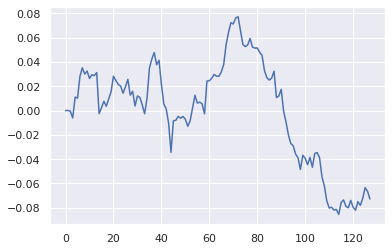

In [ ]:
generator = get_generator()
fixed_noise = get_noise()
print("Base noise:")
gen_path = generator(fixed_noise, training=False).numpy()
log_path = get_log_path((gen_path-np.mean(gen_path)) / np.std(gen_path))

plt.plot(log_path)

In [ ]:
## Actual Training

## Pure TCN log-path generation

Let's try to train a pure TCN generator model. The return process is given by: $R_{t, \theta} = g_{\theta}(Z_{t-(T^{(g)}-1):t})$

for the three-dimensional noise prior $Z_t \overset{iid}{\sim} \mathcal{N}(0, I), (N_Z = 3)$

Base noise:


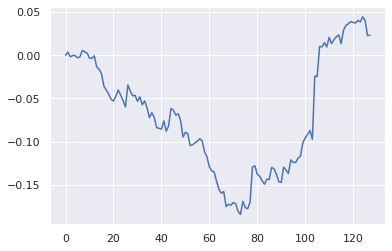

In [ ]:
generator_tcn = get_generator()
discriminator_tcn = get_discriminator()

fixed_noise = get_noise()

print("Base noise:")
fake_series = generator_tcn(fixed_noise, training=False).numpy()
gen_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
plt.plot(gen_path)
plt.show()

====== Epoch  0 ======

Discriminator: 1.9319961071014404, Generator: 1.7655155658721924


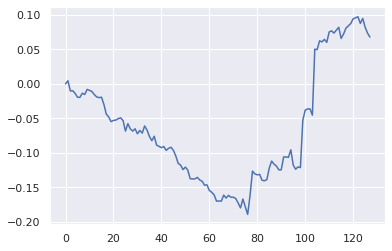

====== Epoch  1 ======

Discriminator: 7.589211463928223, Generator: 0.1481475532054901


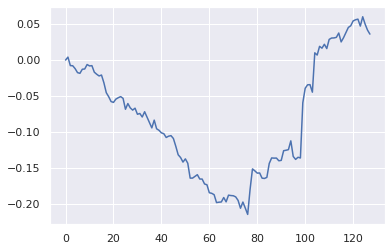

====== Epoch  2 ======

Discriminator: 8.71453857421875, Generator: 0.13250108063220978


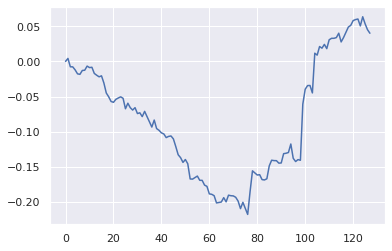

====== Epoch  3 ======

Discriminator: 10.139415740966797, Generator: 0.06448360532522202


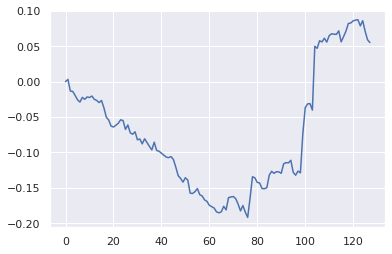

====== Epoch  4 ======

Discriminator: 10.275059700012207, Generator: 0.08254043757915497


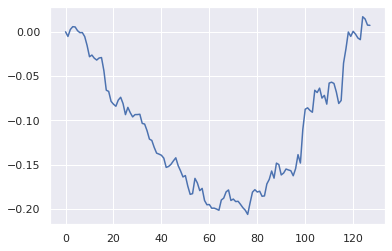

====== Epoch  5 ======

Discriminator: 5.102119445800781, Generator: 0.16797390580177307


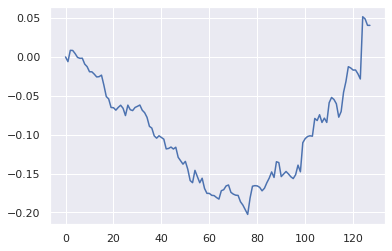

====== Epoch  6 ======

Discriminator: 5.16041374206543, Generator: 0.2045729160308838


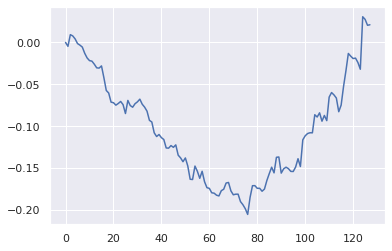

====== Epoch  7 ======

Discriminator: 4.796075344085693, Generator: 0.8990734219551086


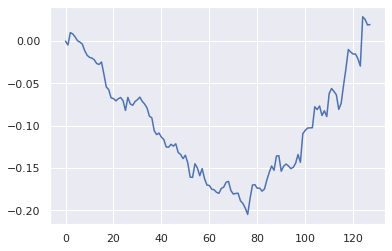

====== Epoch  8 ======

Discriminator: 2.465576410293579, Generator: 0.3969115614891052


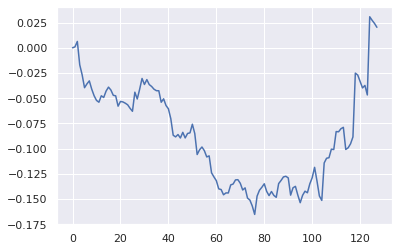

====== Epoch  9 ======

Discriminator: 2.7743582725524902, Generator: 1.1158320903778076


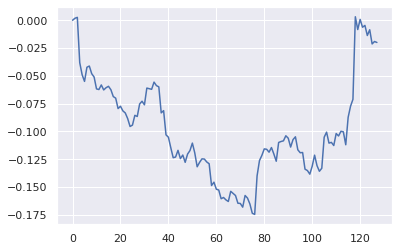

====== Epoch 10 ======

Discriminator: 2.190091848373413, Generator: 0.4267129898071289


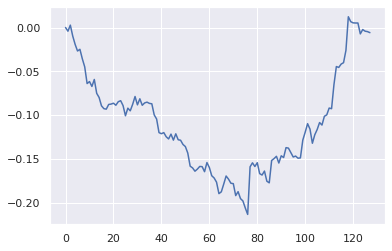

====== Epoch 11 ======

Discriminator: 2.575695753097534, Generator: 0.49933353066444397


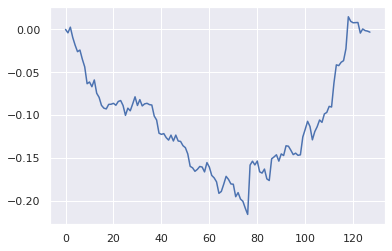

====== Epoch 12 ======

Discriminator: 1.5425221920013428, Generator: 0.4960103929042816


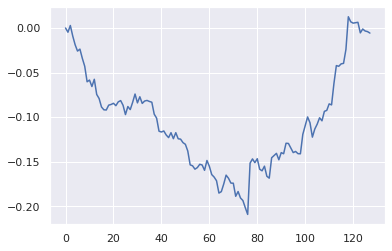

====== Epoch 13 ======

Discriminator: 1.6668287515640259, Generator: 0.42901039123535156


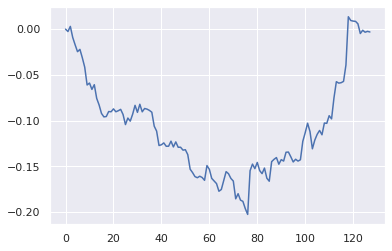

====== Epoch 14 ======

Discriminator: 2.390758514404297, Generator: 0.39471226930618286


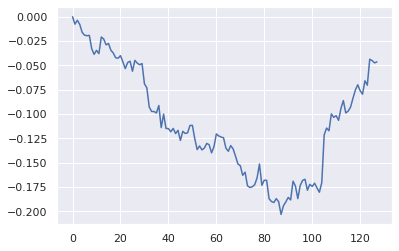

====== Epoch 15 ======

Discriminator: 2.064448118209839, Generator: 0.3257395029067993


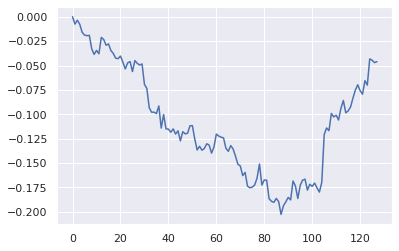

====== Epoch 16 ======

Discriminator: 1.4858471155166626, Generator: 0.4826764464378357


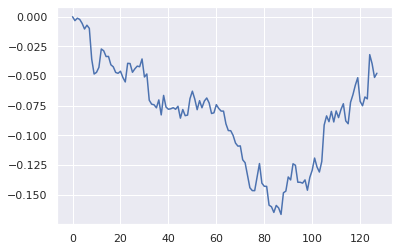

====== Epoch 17 ======

Discriminator: 2.096284866333008, Generator: 0.37773528695106506


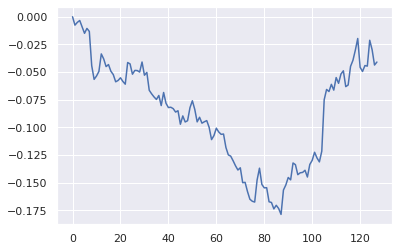

====== Epoch 18 ======

Discriminator: 2.2019481658935547, Generator: 0.44203105568885803


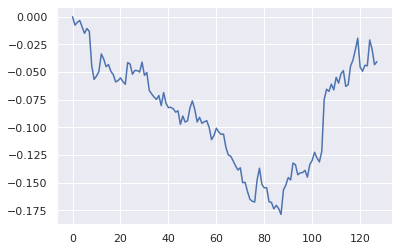

====== Epoch 19 ======

Discriminator: 1.5256106853485107, Generator: 0.42191004753112793


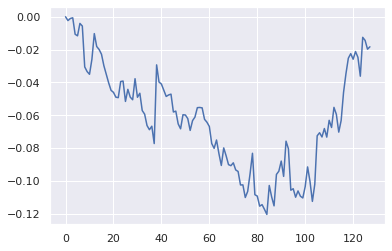

====== Epoch 20 ======

Discriminator: 1.8394567966461182, Generator: 0.4592575132846832


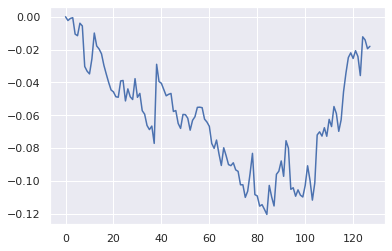

====== Epoch 21 ======

Discriminator: 1.4079139232635498, Generator: 0.5590412020683289


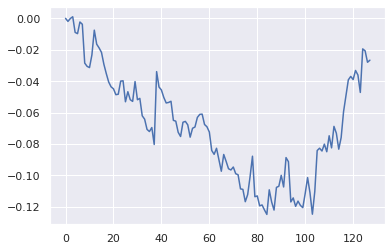

====== Epoch 22 ======

Discriminator: 1.5020090341567993, Generator: 0.41579470038414


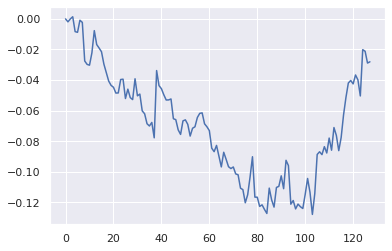

====== Epoch 23 ======

Discriminator: 1.7175896167755127, Generator: 0.38509663939476013


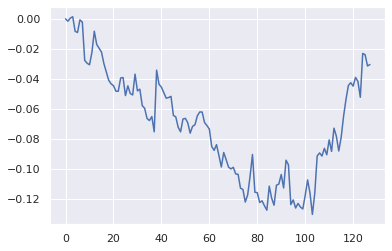

====== Epoch 24 ======

Discriminator: 1.7855037450790405, Generator: 0.3442513644695282


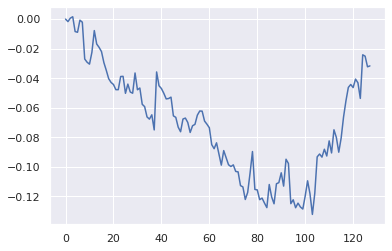

====== Epoch 25 ======

Discriminator: 1.7169405221939087, Generator: 0.38831815123558044


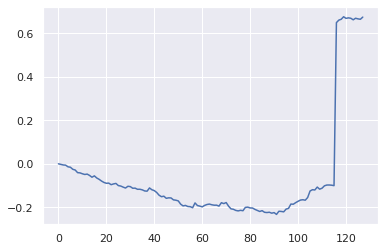

====== Epoch 26 ======

Discriminator: 1.4537689685821533, Generator: 0.4485628604888916


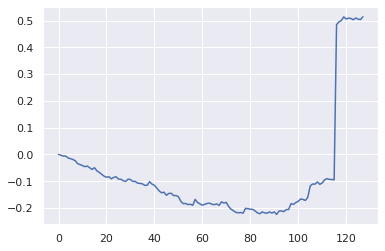

====== Epoch 27 ======

Discriminator: 1.633966088294983, Generator: 0.3792816698551178


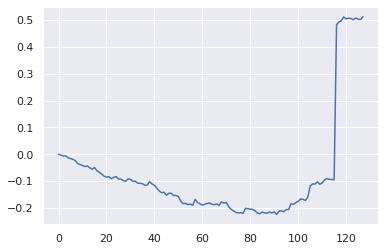

====== Epoch 28 ======

Discriminator: 1.732029914855957, Generator: 0.3441757559776306


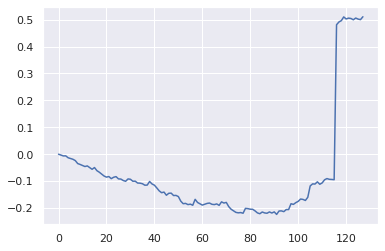

====== Epoch 29 ======

Discriminator: 1.376913070678711, Generator: 0.4788110852241516


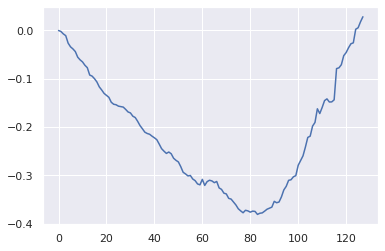

====== Epoch 30 ======

Discriminator: 1.6040000915527344, Generator: 0.37930721044540405


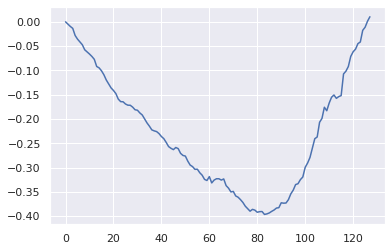

====== Epoch 31 ======

Discriminator: 1.456874132156372, Generator: 0.39972326159477234


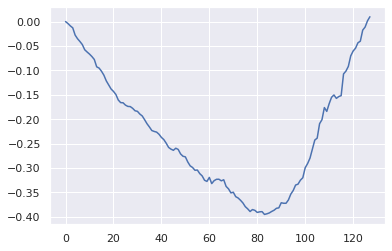

====== Epoch 32 ======

Discriminator: 1.3579418659210205, Generator: 0.4559566080570221


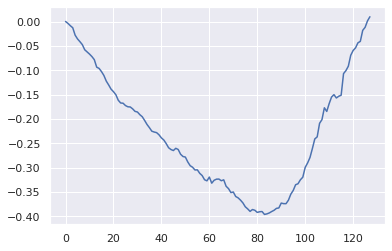

====== Epoch 33 ======

Discriminator: 1.628122329711914, Generator: 0.3489111363887787


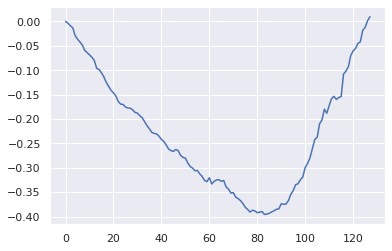

====== Epoch 34 ======

Discriminator: 1.6500440835952759, Generator: 0.3838377594947815


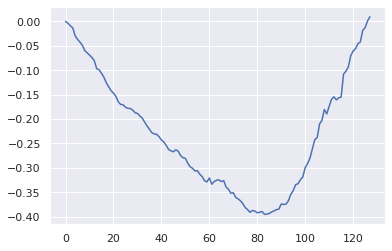

====== Epoch 35 ======

Discriminator: 1.3678300380706787, Generator: 0.41248831152915955


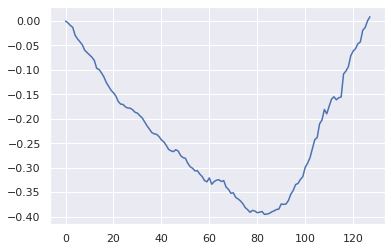

====== Epoch 36 ======

Discriminator: 1.4720815420150757, Generator: 0.3646368682384491


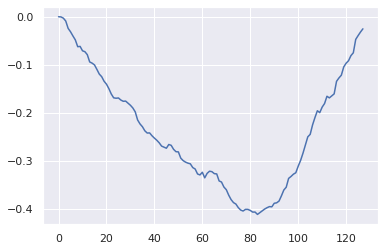

====== Epoch 37 ======

Discriminator: 1.4878658056259155, Generator: 0.42766910791397095


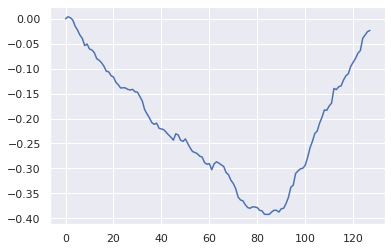

====== Epoch 38 ======

Discriminator: 1.4195458889007568, Generator: 0.45186910033226013


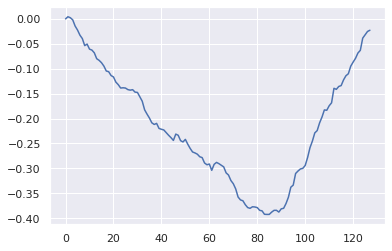

====== Epoch 39 ======

Discriminator: 1.4447420835494995, Generator: 0.40946072340011597


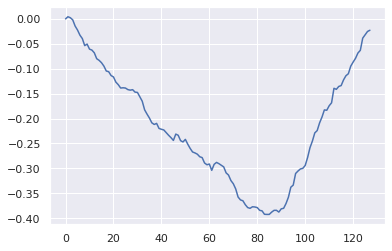

====== Epoch 40 ======

Discriminator: 1.3533918857574463, Generator: 0.4372580945491791


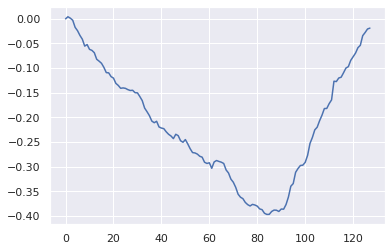

====== Epoch 41 ======

Discriminator: 1.4387006759643555, Generator: 0.41581010818481445


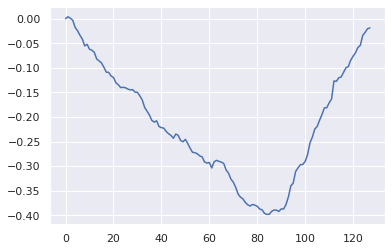

====== Epoch 42 ======

Discriminator: 1.4348528385162354, Generator: 0.4763758182525635


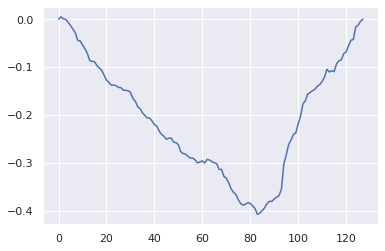

====== Epoch 43 ======

Discriminator: 1.3784546852111816, Generator: 0.45608705282211304


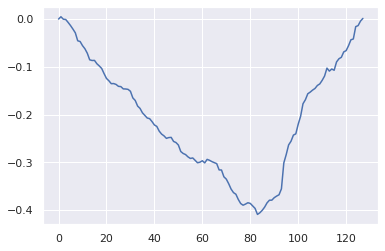

====== Epoch 44 ======

Discriminator: 1.354217529296875, Generator: 0.49361729621887207


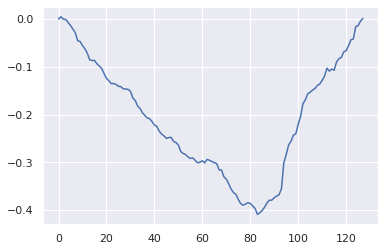

====== Epoch 45 ======

Discriminator: 1.322155237197876, Generator: 0.4895057678222656


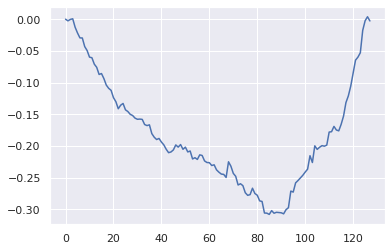

====== Epoch 46 ======

Discriminator: 1.3135286569595337, Generator: 0.5661636590957642


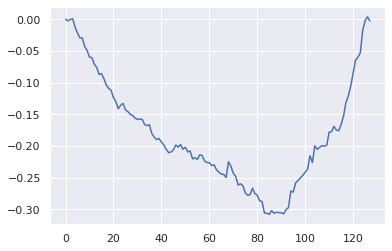

====== Epoch 47 ======

Discriminator: 1.2357263565063477, Generator: 0.5076601505279541


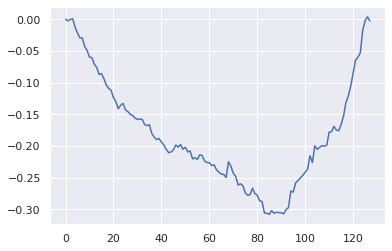

====== Epoch 48 ======

Discriminator: 1.3655836582183838, Generator: 0.5020674467086792


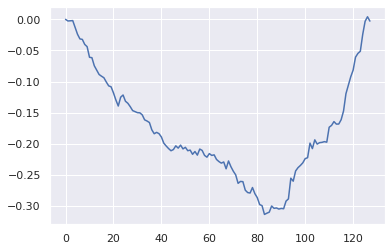

====== Epoch 49 ======

Discriminator: 1.209627628326416, Generator: 0.5277684926986694


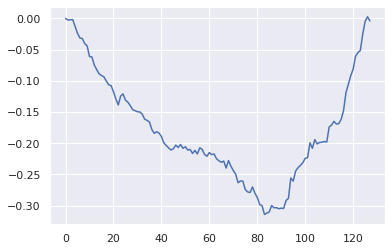

In [ ]:
from tensorflow.keras.metrics import Mean

n_epochs = 50

for epoch in range(n_epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    epoch_loss_d = Mean()
    epoch_loss_g = Mean()

    true_samples = tf.random.shuffle(data_generator)[:20, :, :]
    
    for i, real_series in enumerate(true_samples):
        loss_d, loss_g = train_step(generator_tcn, discriminator_tcn, real_series)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)
    
    print("\nDiscriminator: {}, Generator: {}".format(
        epoch_loss_d.result(), epoch_loss_g.result()))
    fake_series = generator_tcn(fixed_noise, training=False).numpy()
    log_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
    plt.plot(log_path)
    plt.show()

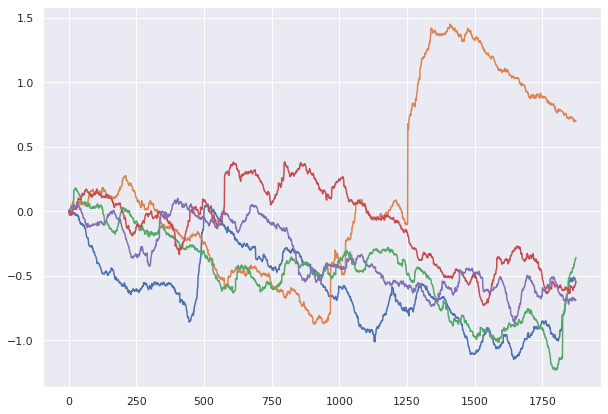

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(5):
  init_noise = get_noise(2000)
  fake_series = generator(init_noise)
  log_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
  plt.plot(log_path)

plt.xlabel('T (number of days)')
plt.ylabel('Log path')
plt.show()

This graph is not completely satisfactory. As we can see, there is a trend for the log paths to decrease, which should not be the case as in the article.

## C-SVNN log-path generation

Let's try to train a constraint SVNN generator model. The log return neural process is defined as: $R_{t, \theta} = \sigma_{t, \theta}\varepsilon_{t, \theta} + \mu_{t, \theta}$

with volatility NP $\sigma_{t, \theta}$, drift NP $\mu_{t, \theta}$ and and innovation NP $\varepsilon_{t, \theta}$ constrained to be i.i.d $\mathcal{N}(0, 1)$ distributed. 


Here again the latent process is i.i.d. Gaussian noise $Z_t \sim \mathcal{N}(0, I)$ for $N_Z = 3$. The
innovation process takes the form $\varepsilon_{t,\theta} = Z_{t,1}$ for any $t \in \mathbb{Z}$.

Base noise:


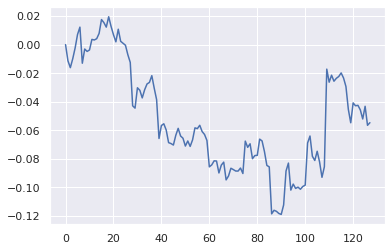

In [ ]:
generator = get_generator(constrain=True)
discriminator = get_discriminator()

fixed_noise = get_noise(constrain=True)

print("Base noise:")
fake_series = generator(fixed_noise, training=False).numpy()
gen_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
plt.plot(gen_path)
plt.show()

====== Epoch  0 ======

Discriminator: 11.964102745056152, Generator: 0.05469520017504692


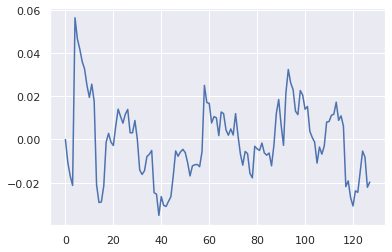

====== Epoch  1 ======

Discriminator: 7.621747016906738, Generator: 0.07673503458499908


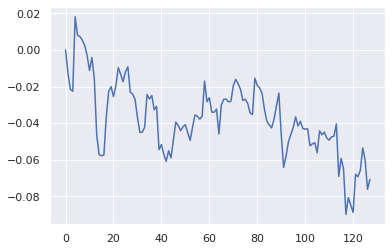

====== Epoch  2 ======

Discriminator: 2.77535343170166, Generator: 0.18749013543128967


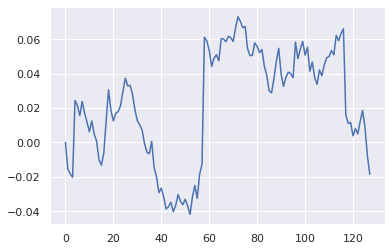

====== Epoch  3 ======

Discriminator: 2.0447998046875, Generator: 0.29467546939849854


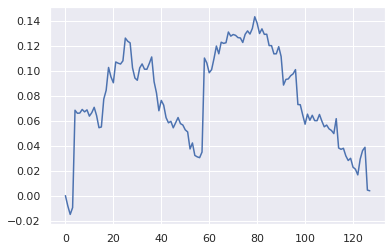

====== Epoch  4 ======

Discriminator: 1.5346577167510986, Generator: 0.32900896668434143


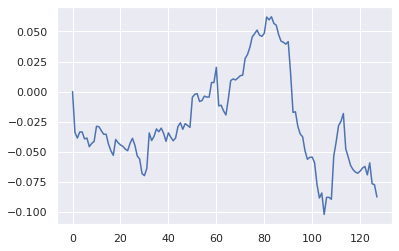

====== Epoch  5 ======

Discriminator: 1.3496863842010498, Generator: 0.5344743132591248


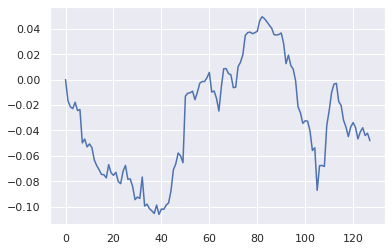

====== Epoch  6 ======

Discriminator: 1.2298755645751953, Generator: 0.4542112350463867


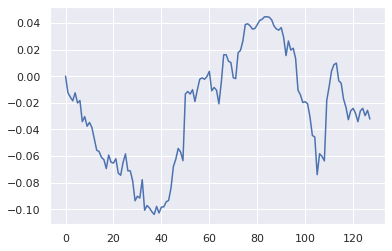

====== Epoch  7 ======

Discriminator: 1.2888360023498535, Generator: 0.40187278389930725


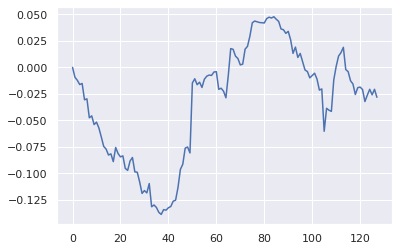

====== Epoch  8 ======

Discriminator: 1.1833945512771606, Generator: 0.4565039277076721


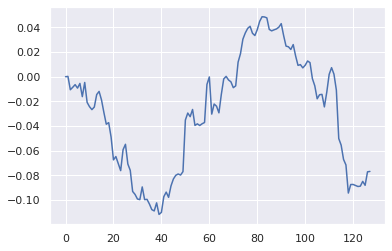

====== Epoch  9 ======

Discriminator: 1.0769271850585938, Generator: 0.5319567918777466


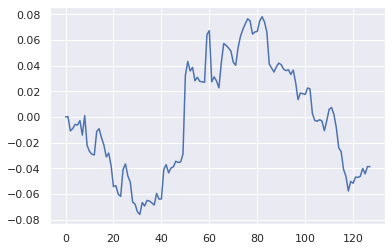

====== Epoch 10 ======

Discriminator: 1.0494352579116821, Generator: 0.515308678150177


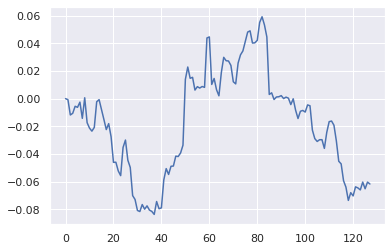

====== Epoch 11 ======

Discriminator: 1.0926474332809448, Generator: 0.4489210546016693


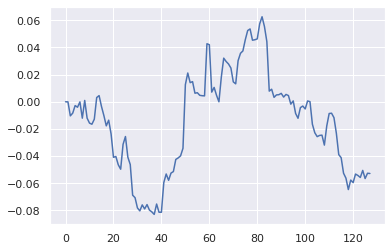

====== Epoch 12 ======

Discriminator: 1.1516386270523071, Generator: 0.4551311135292053


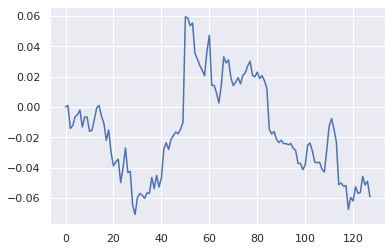

====== Epoch 13 ======

Discriminator: 1.1968940496444702, Generator: 0.4469628930091858


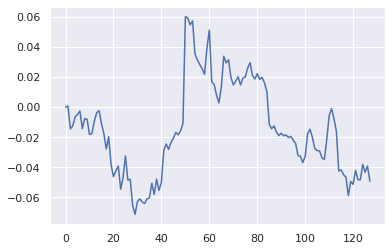

====== Epoch 14 ======

Discriminator: 0.976780116558075, Generator: 0.5619515180587769


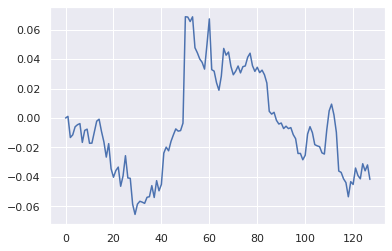

====== Epoch 15 ======

Discriminator: 1.0773557424545288, Generator: 0.4644063115119934


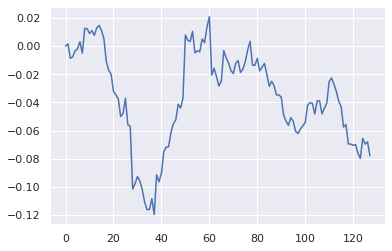

====== Epoch 16 ======

Discriminator: 1.1040561199188232, Generator: 0.4766216278076172


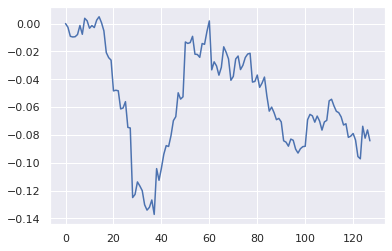

====== Epoch 17 ======

Discriminator: 1.0481603145599365, Generator: 0.47123056650161743


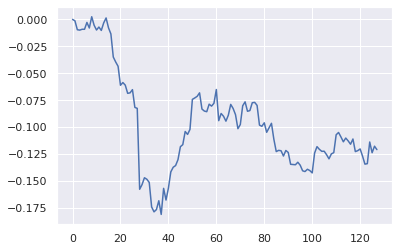

====== Epoch 18 ======

Discriminator: 0.904037356376648, Generator: 0.5771093964576721


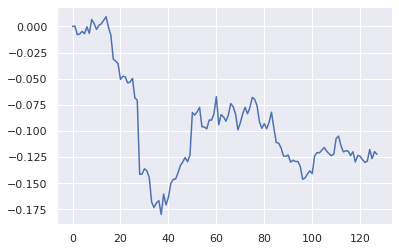

====== Epoch 19 ======

Discriminator: 0.7289904356002808, Generator: 0.7787571549415588


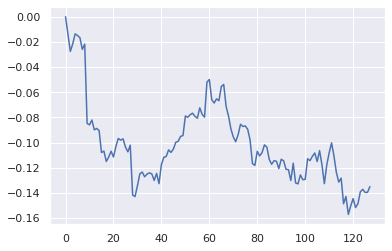

====== Epoch 20 ======

Discriminator: 0.6274031400680542, Generator: 1.6351152658462524


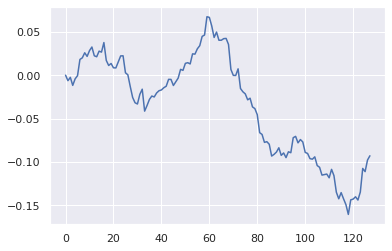

====== Epoch 21 ======

Discriminator: 0.4825822412967682, Generator: 2.7503409385681152


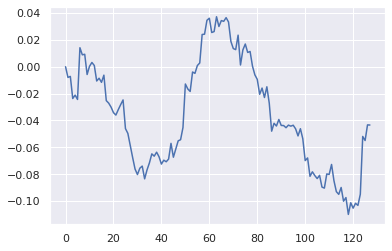

====== Epoch 22 ======

Discriminator: 0.8080375790596008, Generator: 0.6973074674606323


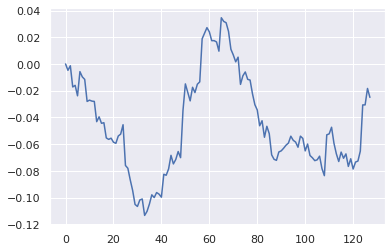

====== Epoch 23 ======

Discriminator: 0.35500484704971313, Generator: 6.940680027008057


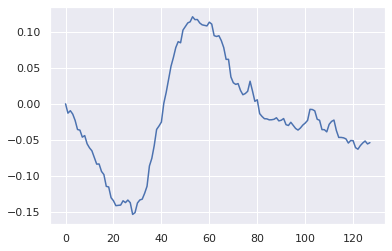

====== Epoch 24 ======

Discriminator: 0.14154832065105438, Generator: 9.902057647705078


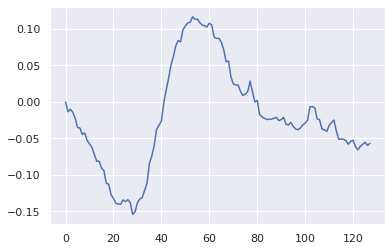

====== Epoch 25 ======

Discriminator: 0.27704089879989624, Generator: 8.741044998168945


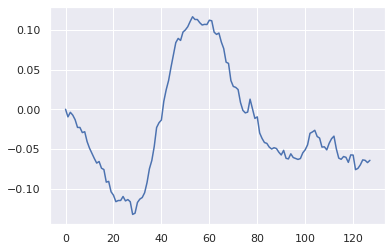

====== Epoch 26 ======

Discriminator: 0.18443036079406738, Generator: 9.56636905670166


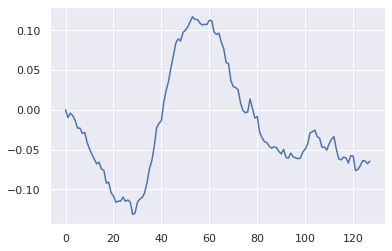

====== Epoch 27 ======

Discriminator: 0.18940484523773193, Generator: 7.7421159744262695


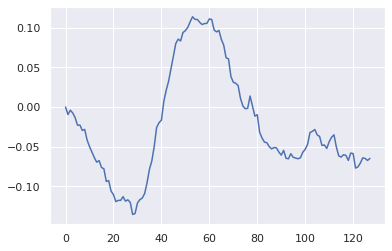

====== Epoch 28 ======

Discriminator: 0.09121334552764893, Generator: 9.99671745300293


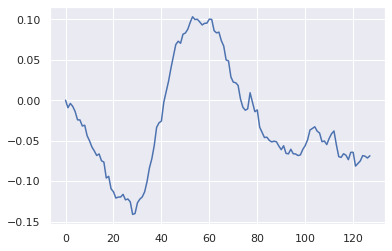

====== Epoch 29 ======

Discriminator: 0.0996483862400055, Generator: 9.641877174377441


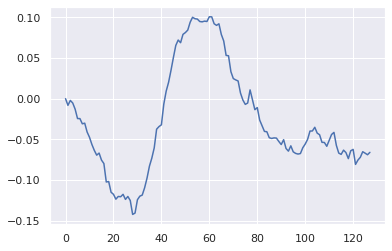

====== Epoch 30 ======

Discriminator: 0.018147047609090805, Generator: 12.07500171661377


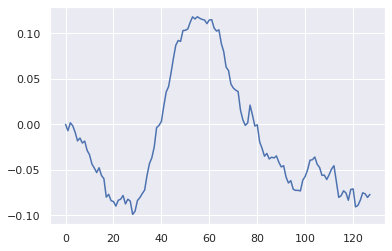

====== Epoch 31 ======

Discriminator: 0.04875224828720093, Generator: 12.246684074401855


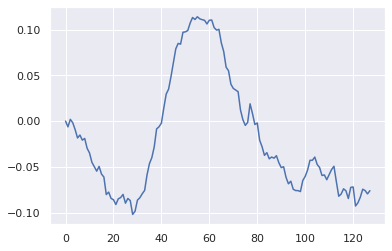

====== Epoch 32 ======

Discriminator: 0.10728688538074493, Generator: 12.029181480407715


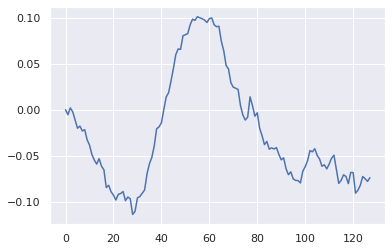

====== Epoch 33 ======

Discriminator: 0.015434453263878822, Generator: 11.552094459533691


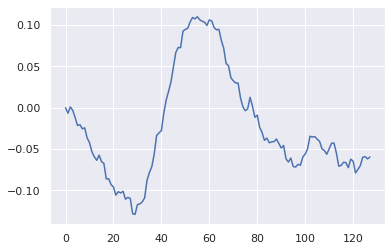

====== Epoch 34 ======

Discriminator: 0.010485169477760792, Generator: 12.906667709350586


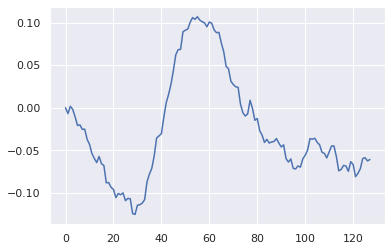

====== Epoch 35 ======

Discriminator: 0.02376469597220421, Generator: 11.591034889221191


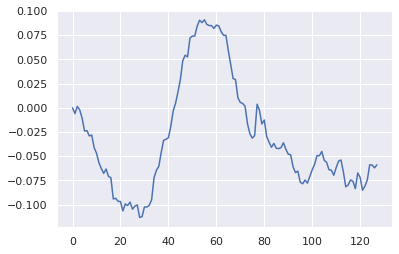

====== Epoch 36 ======

Discriminator: 0.0441378690302372, Generator: 10.97035026550293


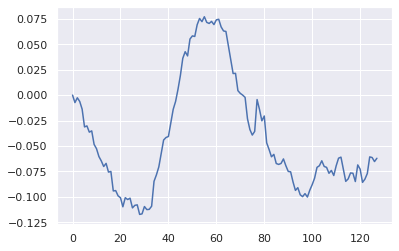

====== Epoch 37 ======

Discriminator: 0.03364656865596771, Generator: 10.616181373596191


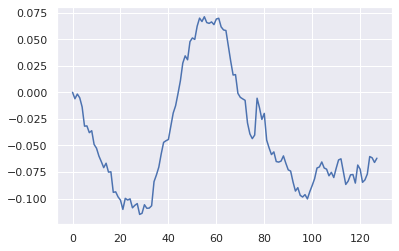

====== Epoch 38 ======

Discriminator: 0.006510484963655472, Generator: 13.906193733215332


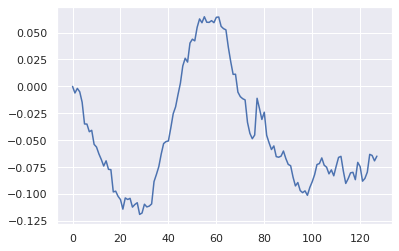

====== Epoch 39 ======

Discriminator: 0.008555577136576176, Generator: 12.822690963745117


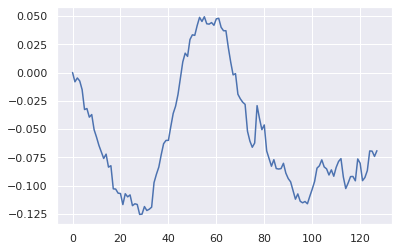

====== Epoch 40 ======

Discriminator: 0.05730677768588066, Generator: 10.459095001220703


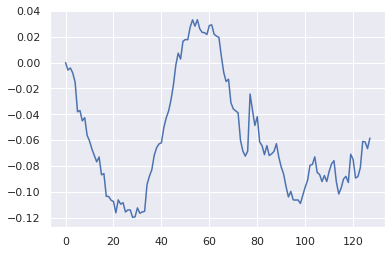

====== Epoch 41 ======

Discriminator: 0.09862889349460602, Generator: 10.50208854675293


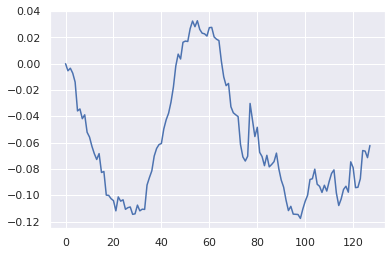

====== Epoch 42 ======

Discriminator: 0.06833367049694061, Generator: 12.660853385925293


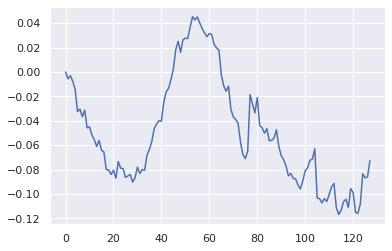

====== Epoch 43 ======

Discriminator: 0.11621765792369843, Generator: 8.628381729125977


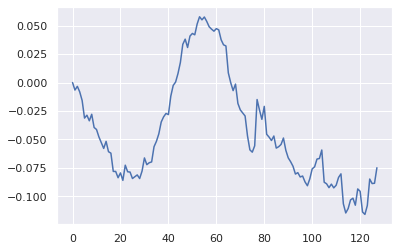

====== Epoch 44 ======

Discriminator: 0.012507103383541107, Generator: 11.95787239074707


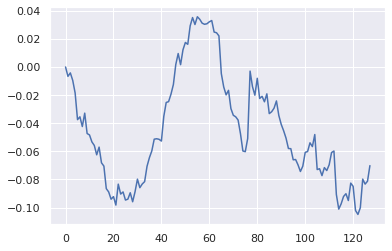

====== Epoch 45 ======

Discriminator: 0.003237033262848854, Generator: 12.535327911376953


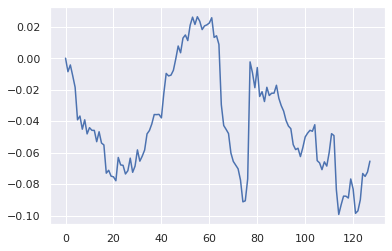

====== Epoch 46 ======

Discriminator: 0.014282992109656334, Generator: 12.572713851928711


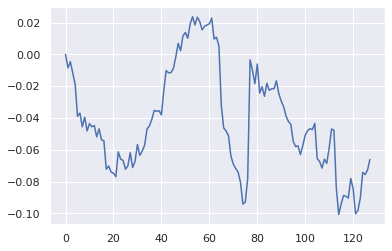

====== Epoch 47 ======

Discriminator: 0.02881241962313652, Generator: 10.511259078979492


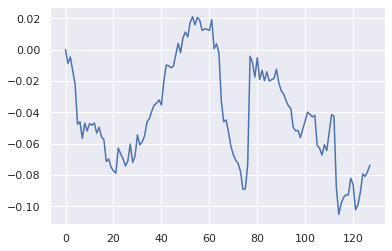

====== Epoch 48 ======

Discriminator: 0.01712164655327797, Generator: 11.300333023071289


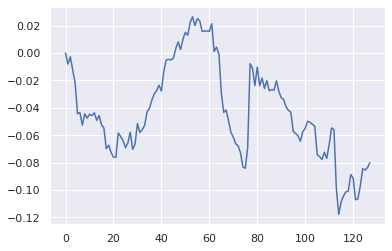

====== Epoch 49 ======

Discriminator: 0.025320833548903465, Generator: 11.822725296020508


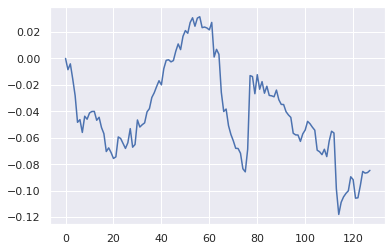

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    epoch_loss_d = Mean()
    epoch_loss_g = Mean()

    true_samples = tf.random.shuffle(data_generator)[:20, :, :]
    
    for i, real_series in enumerate(true_samples):
        loss_d, loss_g = train_step(generator, discriminator, real_series, constrain=True)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)
    
    print("\nDiscriminator: {}, Generator: {}".format(
        epoch_loss_d.result(), epoch_loss_g.result()))
    fake_series = generator(fixed_noise, training=False).numpy()
    log_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
    plt.plot(log_path)
    plt.show()

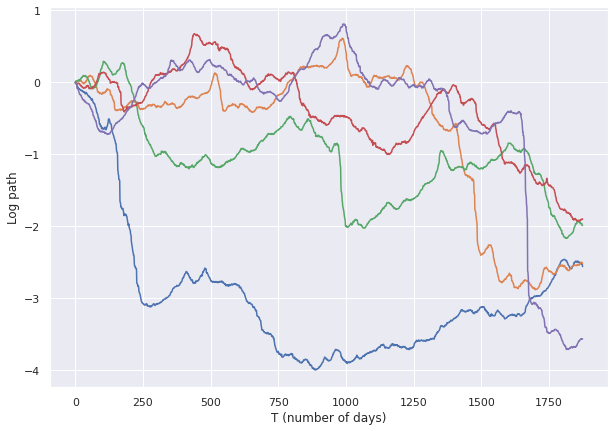

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(5):
  init_noise = get_noise(2000, constrain=True)
  fake_series = generator(init_noise)
  log_path = get_log_path((fake_series-np.mean(fake_series)) / np.std(fake_series))
  plt.plot(log_path)

plt.xlabel('T (number of days)')
plt.ylabel('Log path')
plt.show()

# Conclusion

The objective of time series generation project with Quant GANs was twofold:

* First, we wanted to read about a state-of-the-art technique of time-series generation via unsupervised learning algorithms and comprehend the processes which underlie the method.

* Second, we aimed to reproduce the results of the Quant GANs article by implementing the architecture the authors mention in the paper.  


While we have now a pretty good picture of the mecanisms introduced in the research article and their relevantness, we faced some difficulties to get the implementation of the overall method right. 



Indeed, the research article only gives a vague outline of the coding process. We note that the authors did not release a source code for the model they describe. More importantly, there are a number of technical details essential to the implementation that remain unclear or missing, even after reading the paper. 


1. The authors did not provide the values of some important hyperparameters: for example they did not mention the number of epochs they used to train their generative adversarial network. They did not precise the size of the generator input noise either and consequently the lenght of the tcn layers. We had to make some choices for such hyperparameters resulting in a number of training epochs of 80 and in an input noise's size of 127.

2. The architecture for the innovation neural network is also not mentionned. For this particular step, we decided to implement a vanilla feed forward neural network with three hidden layers and the same activation functions as in the Stochastic Volatility Neural Network. 

3. Even though the authors warn about the irregular training of the method and refer to a GAN stability algorithm, they did not explicitely describe such method. 

